In [1]:
"""
Impl of Value Iteration
"""
import random 
import numpy as np
import gym

In [12]:
import matplotlib.pyplot as plt

def frozen_lake(seed):
    """Defined in :numref:`sec_utils`"""
    # See https://www.gymlibrary.dev/environments/toy_text/frozen_lake/ to learn more about this env
    # How to process env.P.items is adpated from https://sites.google.com/view/deep-rl-bootcamp/labs
    env = gym.make('FrozenLake-v1', is_slippery=False)
    # env.seed(seed) # maybe the code is changed
    # env.action_space.np_random.seed(seed)
    # env.action_space.seed(seed)
    env.reset(seed=seed)
    env_info = {}
    env_info['desc'] = env.desc  # 2D array specifying what each grid item means
    env_info['num_states'] = 16  # Number of observations/states or obs/state dim
    env_info['num_actions'] = 4  # Number of actions or action dim
    # Define indices for (transition probability, nextstate, reward, done) tuple
    env_info['trans_prob_idx'] = 0  # Index of transition probability entry
    env_info['nextstate_idx'] = 1  # Index of next state entry
    env_info['reward_idx'] = 2  # Index of reward entry
    env_info['done_idx'] = 3  # Index of done entry
    env_info['mdp'] = {}
    env_info['env'] = env

    for (s, others) in env.P.items():
        # others(s) = {a0: [ (p(s'|s,a0), s', reward, done),...], a1:[...], ...}

        for (a, pxrds) in others.items():
            # pxrds is [(p1,next1,r1,d1),(p2,next2,r2,d2),..].
            # e.g. [(0.3, 0, 0, False), (0.3, 0, 0, False), (0.3, 4, 1, False)]
            env_info['mdp'][(s,a)] = pxrds

    return env_info

def make_env(name ='', seed=0):
    """Defined in :numref:`sec_utils`"""
    # Input parameters:
    # name: specifies a gym environment.
    # For Value iteration, only FrozenLake-v1 is supported.
    if name == 'FrozenLake-v1':
        return frozen_lake(seed)

    else:
        raise ValueError("%s env is not supported in this Notebook")

def show_value_function_progress(env_desc, V, pi):
    """Defined in :numref:`sec_utils`"""
    # This function visualizes how value and policy changes over time.
    # V: [num_iters, num_states]
    # pi: [num_iters, num_states]
    # How to visualize value function is adapted (but changed) from: https://sites.google.com/view/deep-rl-bootcamp/labs

    num_iters = V.shape[0]
    fig, ax  = plt.subplots(figsize=(15, 15))

    for k in range(V.shape[0]):
        plt.subplot(4, 4, k + 1)
        plt.imshow(V[k].reshape(4,4), cmap="bone")
        ax = plt.gca()
        ax.set_xticks(np.arange(0, 5)-.5, minor=True)
        ax.set_yticks(np.arange(0, 5)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])

        # LEFT action: 0, DOWN action: 1
        # RIGHT action: 2, UP action: 3
        action2dxdy = {0:(-.25, 0),1: (0, .25),
                       2:(0.25, 0),3: (-.25, 0)}

        for y in range(4):
            for x in range(4):
                action = pi[k].reshape(4,4)[y, x]
                dx, dy = action2dxdy[action]

                if env_desc[y,x].decode() == 'H':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="y",
                         size=20, fontweight='bold')

                elif env_desc[y,x].decode() == 'G':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="w",
                         size=20, fontweight='bold')

                else:
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="g",
                         size=15, fontweight='bold')

                # No arrow for cells with G and H labels
                if env_desc[y,x].decode() != 'G' and env_desc[y,x].decode() != 'H':
                    ax.arrow(x, y, dx, dy, color='r', head_width=0.2, head_length=0.15)

        ax.set_title("Step = "  + str(k + 1), fontsize=20)

    fig.tight_layout()
    plt.show()

In [13]:
seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 10  # Number of iterations
random.seed(seed)  # Set the random seed to ensure results can be reproduced
np.random.seed(seed)

# Now set up the environment
env_info = make_env('FrozenLake-v1', seed=seed)

In [26]:
mdp = env_info['mdp']
print(len(mdp))
print(mdp[(0,0)]) # s = 0 -> first in 16 blocks, a = 0 -> action is left
print(mdp) # (p(s'|s,a0), s', reward, done), not slippery so p = 1, s' is the next state, if hit the boundary
# the is will stay in original position. 
# reward will be 1 if next state is goal, otherwise it will be 0
# done: if get into the hole or get to goal, it is true, otherwise it is false.

64
[(1.0, 0, 0.0, False)]
{(0, 0): [(1.0, 0, 0.0, False)], (0, 1): [(1.0, 4, 0.0, False)], (0, 2): [(1.0, 1, 0.0, False)], (0, 3): [(1.0, 0, 0.0, False)], (1, 0): [(1.0, 0, 0.0, False)], (1, 1): [(1.0, 5, 0.0, True)], (1, 2): [(1.0, 2, 0.0, False)], (1, 3): [(1.0, 1, 0.0, False)], (2, 0): [(1.0, 1, 0.0, False)], (2, 1): [(1.0, 6, 0.0, False)], (2, 2): [(1.0, 3, 0.0, False)], (2, 3): [(1.0, 2, 0.0, False)], (3, 0): [(1.0, 2, 0.0, False)], (3, 1): [(1.0, 7, 0.0, True)], (3, 2): [(1.0, 3, 0.0, False)], (3, 3): [(1.0, 3, 0.0, False)], (4, 0): [(1.0, 4, 0.0, False)], (4, 1): [(1.0, 8, 0.0, False)], (4, 2): [(1.0, 5, 0.0, True)], (4, 3): [(1.0, 0, 0.0, False)], (5, 0): [(1.0, 5, 0, True)], (5, 1): [(1.0, 5, 0, True)], (5, 2): [(1.0, 5, 0, True)], (5, 3): [(1.0, 5, 0, True)], (6, 0): [(1.0, 5, 0.0, True)], (6, 1): [(1.0, 10, 0.0, False)], (6, 2): [(1.0, 7, 0.0, True)], (6, 3): [(1.0, 2, 0.0, False)], (7, 0): [(1.0, 7, 0, True)], (7, 1): [(1.0, 7, 0, True)], (7, 2): [(1.0, 7, 0, True)], (7, 3)

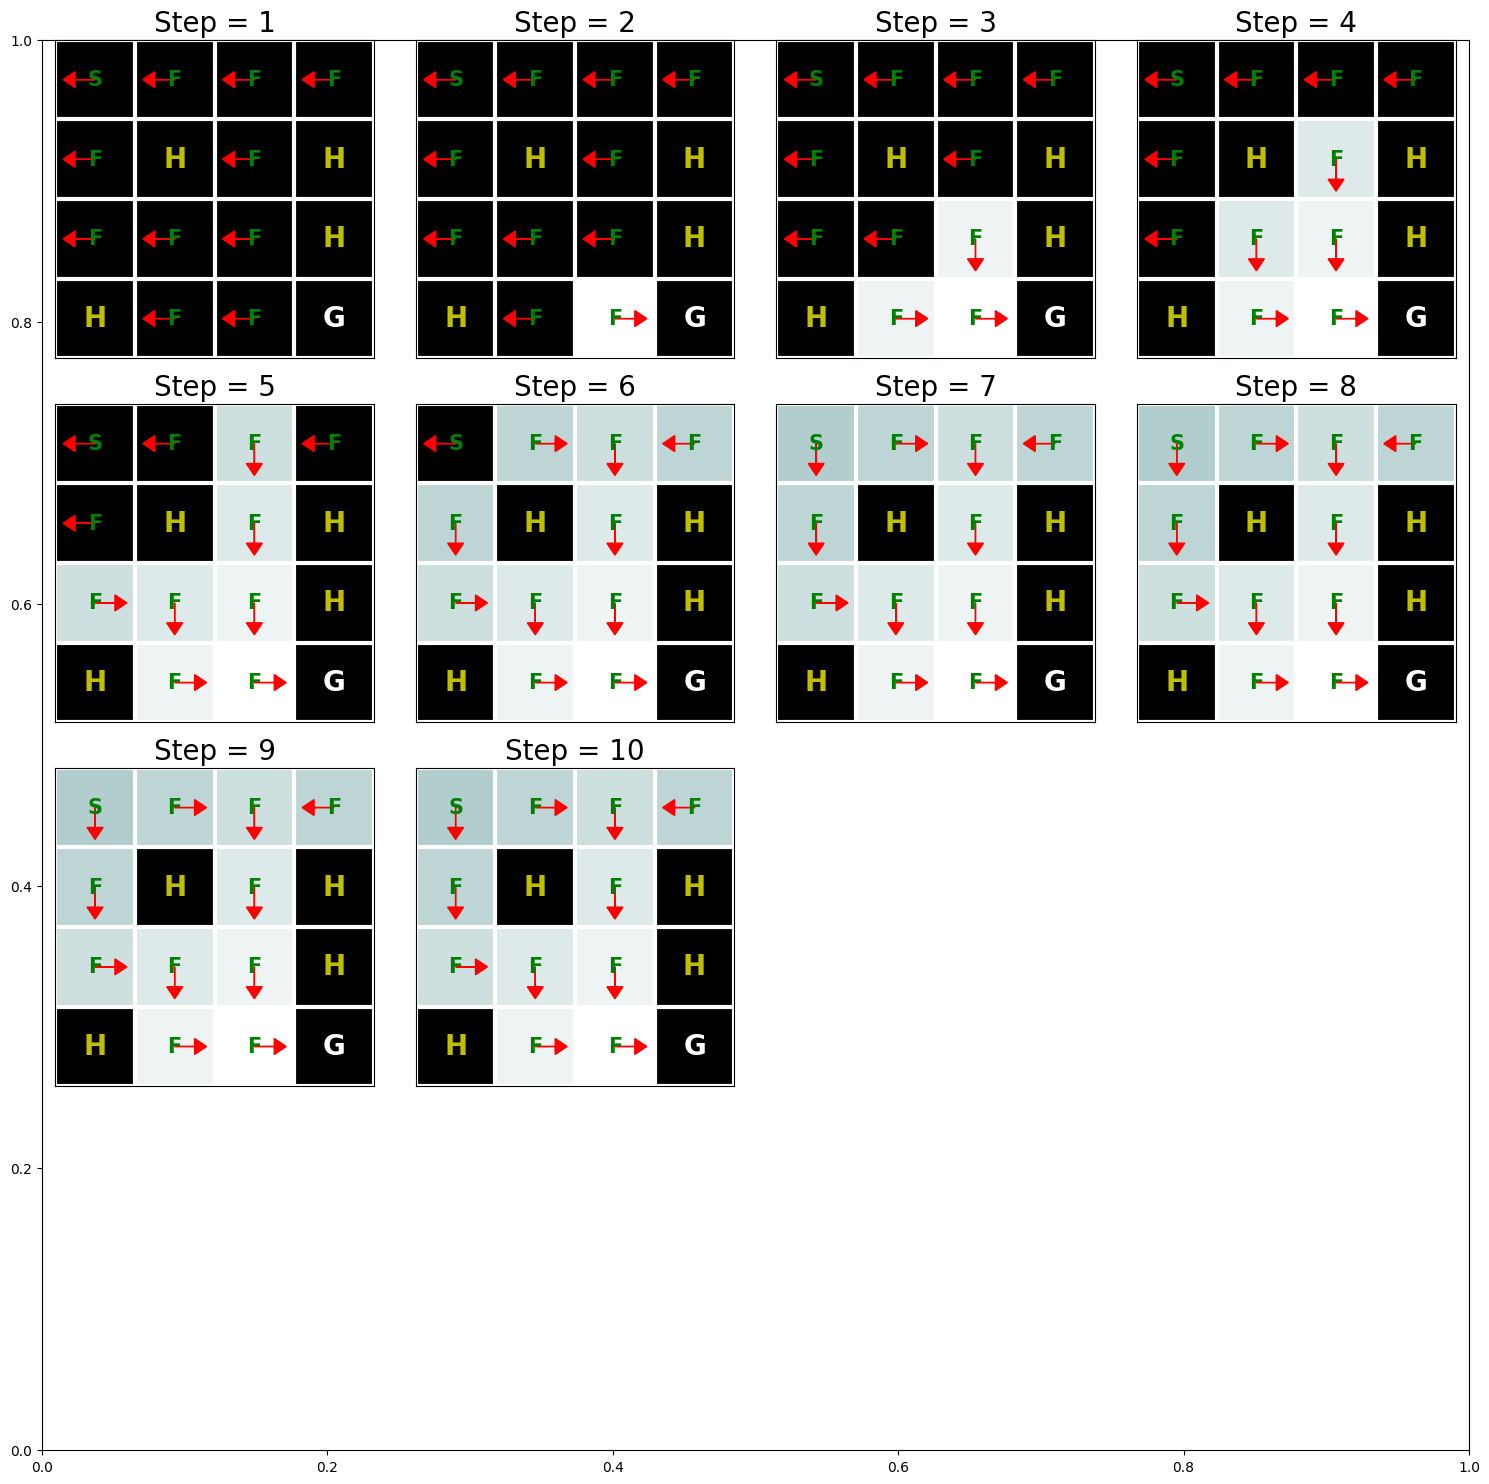

In [15]:
def value_iteration(env_info, gamma, num_iters):
    env_desc = env_info['desc']  # 2D array shows what each item means
    prob_idx = env_info['trans_prob_idx']
    nextstate_idx = env_info['nextstate_idx']
    reward_idx = env_info['reward_idx']
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']
    mdp = env_info['mdp']

    V  = np.zeros((num_iters + 1, num_states))
    Q  = np.zeros((num_iters + 1, num_states, num_actions))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        for s in range(num_states):
            for a in range(num_actions):
                # Calculate \sum_{s'} p(s'\mid s,a) [r + \gamma v_k(s')]
                for pxrds in mdp[(s,a)]:
                    # mdp(s,a): [(p1,next1,r1,d1),(p2,next2,r2,d2),..]
                    pr = pxrds[prob_idx]  # p(s'\mid s,a)
                    nextstate = pxrds[nextstate_idx]  # Next state
                    reward = pxrds[reward_idx]  # Reward
                    # This form assume reward depend only on next state s'
                    # if put it as reward + pr * gamma * V[k - 1, nextstate], we assume reward only depend on (a,s)
                    Q[k,s,a] += pr * (reward + gamma * V[k - 1, nextstate])
            # Record max value and max action
            # max means this is deterministic policy, if use average weighted sum, the stochastic policy.
            V[k,s] = np.max(Q[k,s,:])
            pi[k,s] = np.argmax(Q[k,s,:])
    show_value_function_progress(env_desc, V[:-1], pi[:-1])

value_iteration(env_info=env_info, gamma=gamma, num_iters=num_iters)